Adapted from : https://towardsdatascience.com/umap-variance-explained-b0eacb5b0801

In [124]:
from matplotlib import pyplot
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from numpy import linalg as la 
from itertools import chain
import collections
from sklearn.preprocessing import StandardScaler

In [125]:
df=pd.read_csv("normalized_feature_select_batch.csv") # this data contains approx 500 features

In [126]:
features = pd.read_csv("Sheet 1-Table 1.csv")#initialising the columns in the data as features

In [127]:
f = features.to_numpy() #converting dataframe to numpy array
f_1 = f.flatten() #to convert a multidimentional array f to a single array f_1

In [128]:
#accessing values of the entire columns in f_1 and storing in x
x = df.loc[:, f_1].values # Separating out the features
#accessing values of the entire column of Metadata_Welll and storing in y
y = df.loc[:,['Metadata_Well']].values #Separating out target

In [129]:
x_1 = StandardScaler().fit_transform(x) 
np.random.seed(384)
random_indices = np.random.choice(384, replace=False)
# x_1 = x_1[random_indices,:]
labels = random_indices

Observed variance explained:
[0.22281402 0.18196501 0.08224385 0.06172864 0.04600458 0.03581679
 0.02850935 0.02558085 0.02402026 0.02292681]


Finished 1 permutations
Finished 2 permutations
Finished 3 permutations
Finished 4 permutations
Finished 5 permutations
Finished 6 permutations
Finished 7 permutations
Finished 8 permutations
Finished 9 permutations
Finished 10 permutations

Permuted variance explained:
[0.00993547827535998, 0.009599666053496485, 0.009385988085084574, 0.009179999055498982, 0.009050824709864569, 0.008864419191010397, 0.008765596192184583, 0.008674841297214702, 0.00850139477482224, 0.008349321761132443]

Number of significant Principal Components: 18
Together they explain 84% of variation in the data


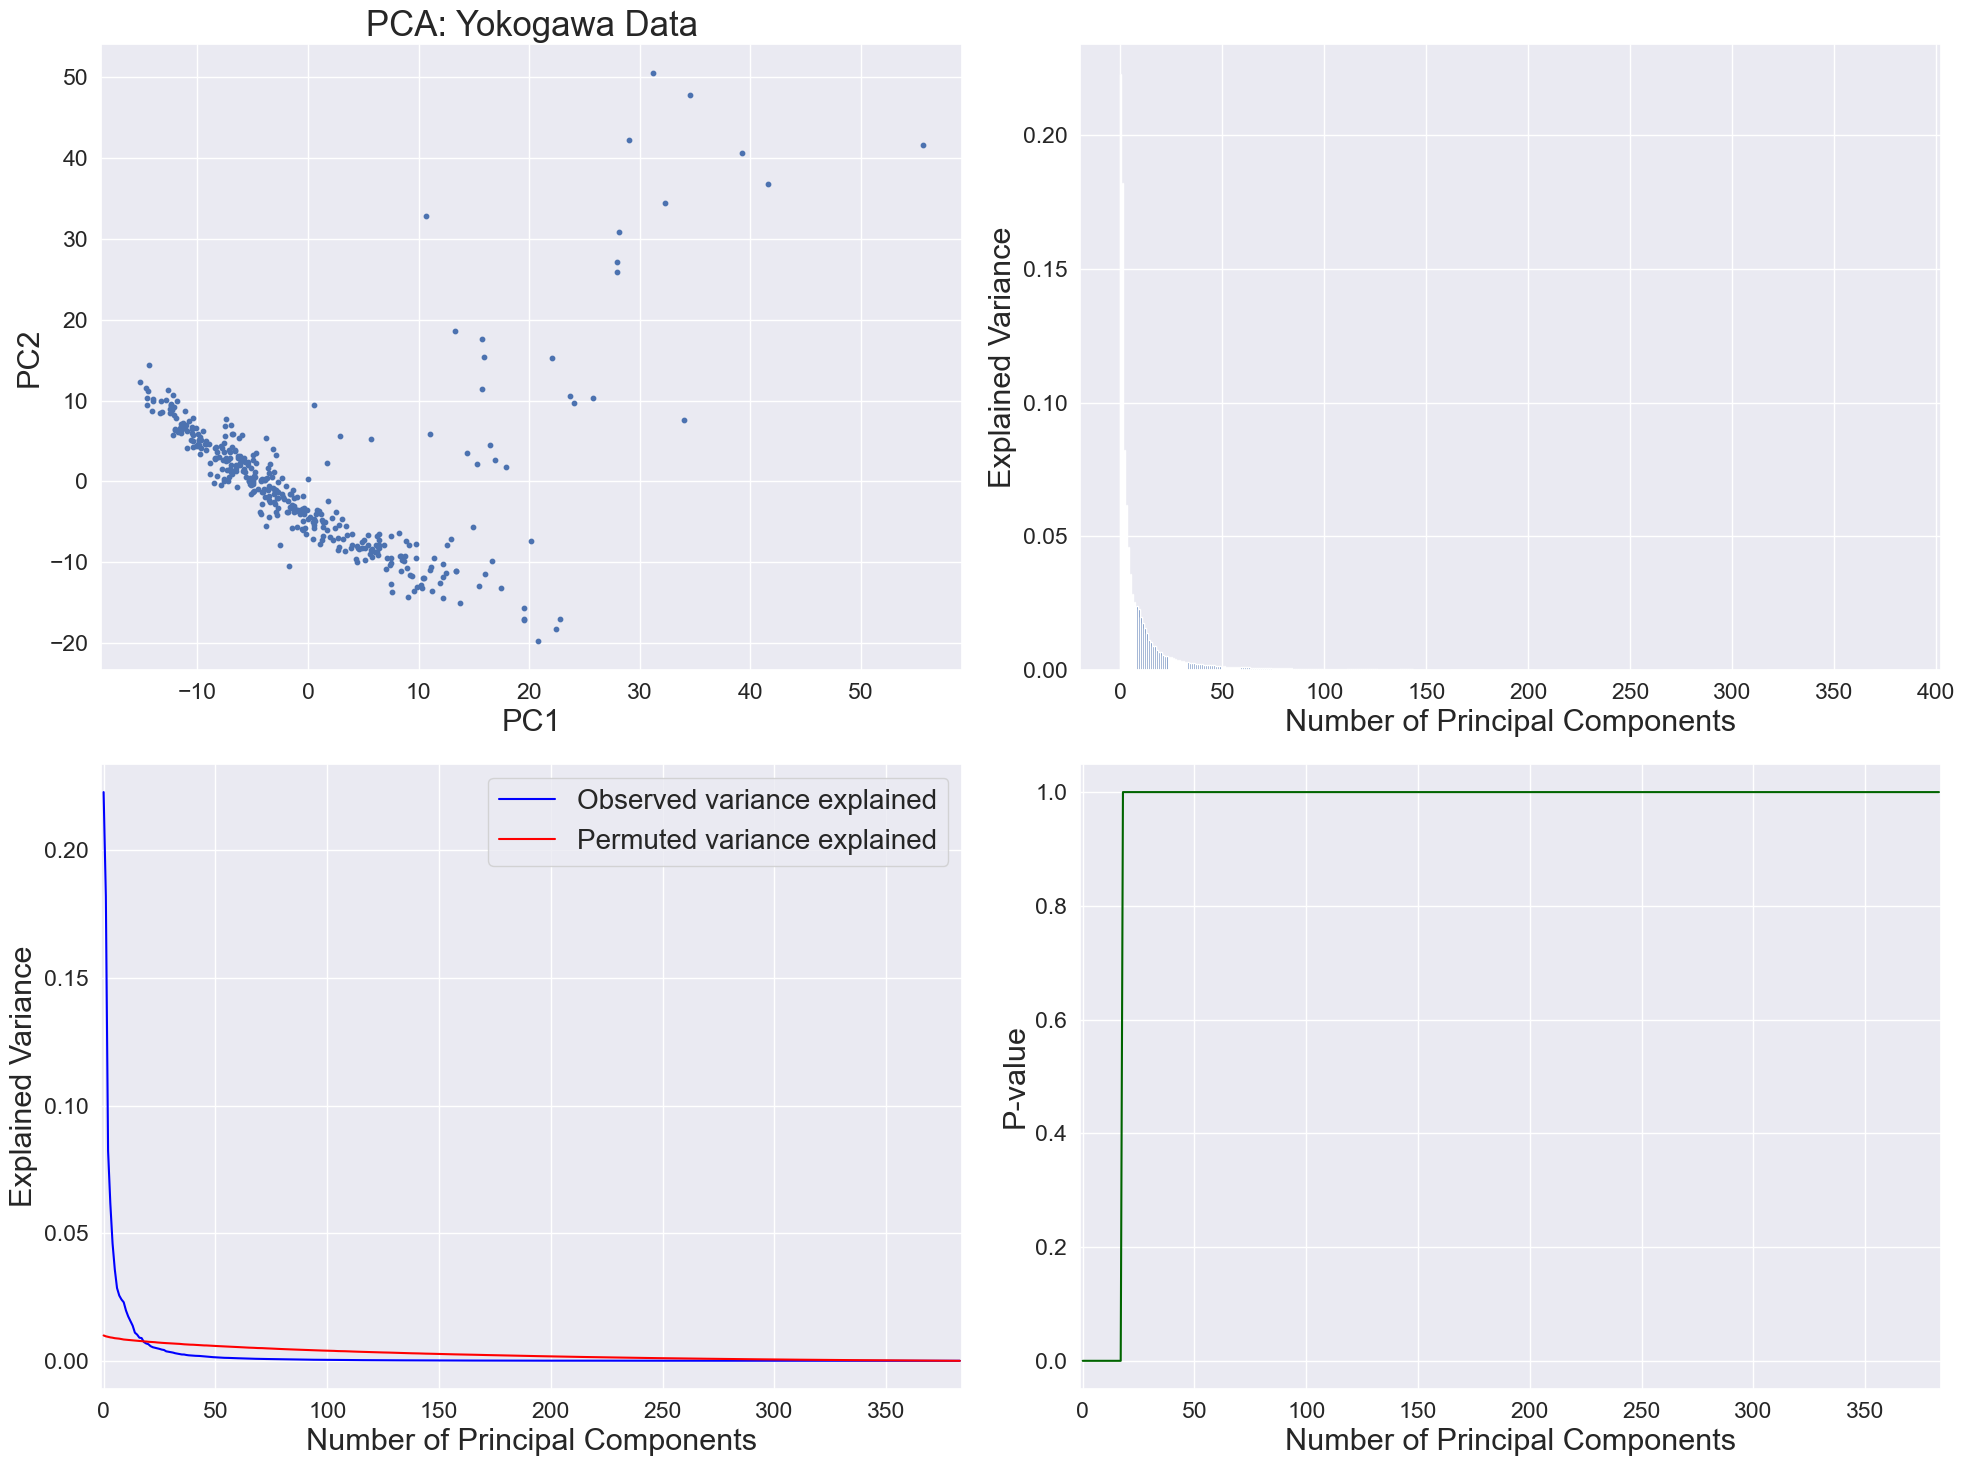

In [130]:
import pandas as pd; import matplotlib.pyplot as plt
from sklearn.decomposition import PCA; import seaborn as sns

N_pca_comps = 384

sns.set(font_scale = 1.5); figure = plt.figure(figsize = (20, 15))

plt.subplot(221)
X_reduced = PCA(n_components = 2).fit_transform(x_1)
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=10)
plt.title('PCA: Yokogawa Data', fontsize = 25)
plt.xlabel('PC1', fontsize = 22); plt.ylabel('PC2', fontsize = 22)

plt.subplot(222)
pca = PCA(n_components = N_pca_comps).fit(x_1)
print('Observed variance explained:')
print(pca.explained_variance_ratio_[0:10]); print('\n')
plt.bar(range(len(pca.explained_variance_ratio_)), 
        pca.explained_variance_ratio_)
plt.xlabel('Number of Principal Components', fontsize = 22)
plt.ylabel('Explained Variance', fontsize = 22)

N_perm = 10
X_flat = x_1.flatten()
expl_var_perm_df = pd.DataFrame(index = list(range(N_perm)), 
                                columns = list(range(384)))
for i in range(N_perm):
    np.random.shuffle(X_flat)
    X_perm = X_flat.reshape(x_1.shape[0], x_1.shape[1])
    pca_perm = PCA().fit(X_perm)
    expl_var_perm_df.loc[i] = pca_perm.explained_variance_ratio_
    print('Finished {} permutations'.format(i + 1))
    X_perm = list(expl_var_perm_df.mean(axis = 0) + 2*expl_var_perm_df.std(axis = 0)) 

print('\nPermuted variance explained:')
print(X_perm[0:10])

plt.subplot(223)
plt.plot(pca.explained_variance_ratio_, c = 'blue')
plt.plot(X_perm, c = 'red'); plt.xlim([-1, N_pca_comps])
plt.xlabel('Number of Principal Components', fontsize = 22)
plt.ylabel('Explained Variance', fontsize = 22)
plt.gca().legend(('Observed variance explained', 
                  'Permuted variance explained'), fontsize = 20)

plt.subplot(224)
pval = list()
for j in range(N_pca_comps):
    pval.append(np.sum(expl_var_perm_df.iloc[:, j] + 
                       2*expl_var_perm_df.std(axis = 0) >= 
                       pca.explained_variance_ratio_[j]) / N_perm)
plt.plot(pval, c = 'darkgreen')
plt.xlabel('Number of Principal Components', fontsize = 22)
plt.ylabel('P-value', fontsize = 22); plt.xlim([-1, N_pca_comps])
N_opt_pcs = np.where(np.array(pval) >= 0.05)[0][0]
print('\nNumber of significant Principal Components: {}'.format(N_opt_pcs))
print('Together they explain {}% of variation in the data'.\
format(int(round(sum(pca.explained_variance_ratio_[0:\
np.where(np.array(pval) >= 0.05)[0][0]])*100,0))))

figure.tight_layout()
plt.show()

In [131]:
import umap.umap_ as umap
from sklearn.manifold import TSNE; from sklearn.decomposition import PCA


## PCA vs tSNE vs UMAP - Cell count 

In [134]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [135]:
opt_perp = np.int64(np.round(np.sqrt(x_1.shape[0]), 0))
X_reduced = PCA(n_components = N_opt_pcs).fit_transform(x_1)

umap_embedding = umap.UMAP(n_components = 2, n_neighbors = opt_perp, 
                           init = X_reduced[:, 0:2], 
                           min_dist=0.3, n_epochs = 1000, random_state = 123, 
                           verbose = 0).fit_transform(X_reduced)

tsne_embedding = TSNE(n_components=2, perplexity=opt_perp, 
                      init=X_reduced[:, 0:2], 
                      learning_rate = 200, n_iter = 1000, random_state = 123, 
                      verbose = 0).fit_transform(X_reduced)

In [136]:
# create a pandas dataframe for the embeddings
d = pd.DataFrame({'tsne_x': tsne_embedding[:, 0], 'tsne_y': tsne_embedding[:, 1],
                   'umap_x': umap_embedding[:, 0], 'umap_y': umap_embedding[:, 1],
                  'pca_x' : X_reduced[:,0], 'pca_y': X_reduced[:,1]})

# create the scatter plot with hover information

fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(x=d['pca_x'], y=d['pca_y'], mode='markers',
                         marker=dict(color=df["Metadata_Count_Cells"]),
                         name='PCA',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells"]],
                         hovertemplate=
                         '<b>PCA Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'
                         '<extra></extra>'), row=1, col=1)

fig.add_trace(go.Scatter(x=d['tsne_x'], y=d['tsne_y'], mode='markers',
                         marker=dict(color=df["Metadata_Count_Cells"]),
                         name='t-SNE',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells"]],
                         hovertemplate=
                         '<b>t-SNE Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'
                         '<extra></extra>'), row=1, col=2)

fig.add_trace(go.Scatter(x=d['umap_x'], y=d['umap_y'], mode='markers',
                         marker=dict(color=df["Metadata_Count_Cells"]),
                         name='UMAP',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells"]],
                         hovertemplate=
                         '<b>UMAP Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'
                         '<extra></extra>'), row=1, col=3)


fig.update_xaxes(title_text="PCA1", row=1, col=1)
fig.update_yaxes(title_text="PCA2", row=1, col=1)
fig.update_xaxes(title_text="tSNE1", row=1, col=2)
fig.update_yaxes(title_text="tSNE2", row=1, col=2)
fig.update_xaxes(title_text="UMAP1", row=1, col=3)
fig.update_yaxes(title_text="UMAP2", row=1, col=3)
fig.update_layout(title_text="PCA vs tSNE vs UMAP")



fig.show()


## PCA vs tSNE vs UMAP - RNA intensity

In [137]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(x=d['pca_x'], y=d['pca_y'], mode='markers',
                         marker=dict(color=df["Cells_Intensity_IntegratedIntensity_RNA"]),
                         name='PCA',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_IntegratedIntensity_RNA"]],
                         hovertemplate=
                         '<b>PCA Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>' 
                         '<extra></extra>'), row=1, col=1)

fig.add_trace(go.Scatter(x=d['tsne_x'], y=d['tsne_y'], mode='markers',
                         marker=dict(color=df["Cells_Intensity_IntegratedIntensity_RNA"]),
                         name='t-SNE',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_IntegratedIntensity_RNA"]],
                         hovertemplate=
                         '<b>t-SNE Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>' 
                         '<extra></extra>'), row=1, col=2)

fig.add_trace(go.Scatter(x=d['umap_x'], y=d['umap_y'], mode='markers',
                         marker=dict(color=df["Cells_Intensity_IntegratedIntensity_RNA"]),
                         name='UMAP',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_IntegratedIntensity_RNA"]],
                         hovertemplate=
                         '<b>UMAP Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>' 
                         '<extra></extra>'), row=1, col=3)


fig.update_xaxes(title_text="PCA1", row=1, col=1)
fig.update_yaxes(title_text="PCA2", row=1, col=1)
fig.update_xaxes(title_text="tSNE1", row=1, col=2)
fig.update_yaxes(title_text="tSNE2", row=1, col=2)
fig.update_xaxes(title_text="UMAP1", row=1, col=3)
fig.update_yaxes(title_text="UMAP2", row=1, col=3)
fig.update_layout(title_text="PCA vs tSNE vs UMAP")



fig.show()


## PCA vs tSNE vs UMAP - Area Shape

In [138]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(x=d['pca_x'], y=d['pca_y'], mode='markers',
                         marker=dict(color=df["Cells_AreaShape_Solidity"]),
                         name='PCA',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity"]],
                         hovertemplate=
                         '<b>PCA Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>'
                         '<extra></extra>'), row=1, col=1)

fig.add_trace(go.Scatter(x=d['tsne_x'], y=d['tsne_y'], mode='markers',
                         marker=dict(color=df["Cells_AreaShape_Solidity"]),
                         name='t-SNE',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity"]],
                         hovertemplate=
                         '<b>t-SNE Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>' 
                         '<extra></extra>'), row=1, col=2)

fig.add_trace(go.Scatter(x=d['umap_x'], y=d['umap_y'], mode='markers',
                         marker=dict(color=df["Cells_AreaShape_Solidity"]),
                         name='UMAP',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity"]],
                         hovertemplate=
                         '<b>UMAP Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>' 
                         '<extra></extra>'), row=1, col=3)


fig.update_xaxes(title_text="PCA1", row=1, col=1)
fig.update_yaxes(title_text="PCA2", row=1, col=1)
fig.update_xaxes(title_text="tSNE1", row=1, col=2)
fig.update_yaxes(title_text="tSNE2", row=1, col=2)
fig.update_xaxes(title_text="UMAP1", row=1, col=3)
fig.update_yaxes(title_text="UMAP2", row=1, col=3)
fig.update_layout(title_text="PCA vs tSNE vs UMAP")



fig.show()


## PCA vs tSNE vs UMAP - DNA granularity

In [139]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(x=d['pca_x'], y=d['pca_y'], mode='markers',
                         marker=dict(color=df["Cells_Granularity_1_DNA"]),
                         name='PCA',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity","Cells_Granularity_1_DNA"]],
                         hovertemplate=
                         '<b>PCA Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>'+
                         'DNA_granularity: %{text[4]}<br>'
                         '<extra></extra>'), row=1, col=1)

fig.add_trace(go.Scatter(x=d['tsne_x'], y=d['tsne_y'], mode='markers',
                         marker=dict(color=df["Cells_Granularity_1_DNA"]),
                         name='t-SNE',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity","Cells_Granularity_1_DNA"]],
                         hovertemplate=
                         '<b>t-SNE Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>'+
                         'DNA_granularity: %{text[4]}<br>' 
                         '<extra></extra>'), row=1, col=2)

fig.add_trace(go.Scatter(x=d['umap_x'], y=d['umap_y'], mode='markers',
                         marker=dict(color=df["Cells_Granularity_1_DNA"]),
                         name='UMAP',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity","Cells_Granularity_1_DNA"]],
                         hovertemplate=
                         '<b>UMAP Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>'+
                         'DNA_granularity: %{text[4]}<br>'
                         '<extra></extra>'), row=1, col=3)


fig.update_xaxes(title_text="PCA1", row=1, col=1)
fig.update_yaxes(title_text="PCA2", row=1, col=1)
fig.update_xaxes(title_text="tSNE1", row=1, col=2)
fig.update_yaxes(title_text="tSNE2", row=1, col=2)
fig.update_xaxes(title_text="UMAP1", row=1, col=3)
fig.update_yaxes(title_text="UMAP2", row=1, col=3)
fig.update_layout(title_text="PCA vs tSNE vs UMAP")



fig.show()


## PCA vs tSNE vs UMAP - Angle Between Adjacent Neighbours

In [140]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(x=d['pca_x'], y=d['pca_y'], mode='markers',
                         marker=dict(color=df["Cells_Neighbors_AngleBetweenNeighbors_Adjacent"]),
                         name='PCA',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity","Cells_Granularity_1_DNA","Cells_Neighbors_AngleBetweenNeighbors_Adjacent"]],
                         hovertemplate=
                         '<b>PCA Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>'+
                         'DNA_granularity: %{text[4]}<br>'+
                         'AngleBetweenNeighbors_Adjacent: %{text[5]}<br>'
                         '<extra></extra>'), row=1, col=1)

fig.add_trace(go.Scatter(x=d['tsne_x'], y=d['tsne_y'], mode='markers',
                         marker=dict(color=df["Cells_Neighbors_AngleBetweenNeighbors_Adjacent"]),
                         name='t-SNE',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity","Cells_Granularity_1_DNA","Cells_Neighbors_AngleBetweenNeighbors_Adjacent"]],
                         hovertemplate=
                         '<b>t-SNE Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>'+
                         'DNA_granularity: %{text[4]}<br>'+
                         'AngleBetweenNeighbors_Adjacent: %{text[5]}<br>' 
                         '<extra></extra>'), row=1, col=2)

fig.add_trace(go.Scatter(x=d['umap_x'], y=d['umap_y'], mode='markers',
                         marker=dict(color=df["Cells_Neighbors_AngleBetweenNeighbors_Adjacent"]),
                         name='UMAP',
                         text=df[["Metadata_pert_iname","Metadata_Count_Cells","Cells_Intensity_MinIntensityEdge_RNA","Cells_AreaShape_Solidity","Cells_Granularity_1_DNA","Cells_Neighbors_AngleBetweenNeighbors_Adjacent"]],
                         hovertemplate=
                         '<b>UMAP Embedding</b><br><br>' +
                         'Pertubation: %{text[0]}<br>' +
                         'Cellcount: %{text[1]}<br>'+
                         'RNA_intensity: %{text[2]}<br>'+
                         'Areashape: %{text[3]}<br>'+
                         'DNA_granularity: %{text[4]}<br>'+
                         'AngleBetweenNeighbors_Adjacent: %{text[5]}<br>'
                         '<extra></extra>'), row=1, col=3)


fig.update_xaxes(title_text="PCA1", row=1, col=1)
fig.update_yaxes(title_text="PCA2", row=1, col=1)
fig.update_xaxes(title_text="tSNE1", row=1, col=2)
fig.update_yaxes(title_text="tSNE2", row=1, col=2)
fig.update_xaxes(title_text="UMAP1", row=1, col=3)
fig.update_yaxes(title_text="UMAP2", row=1, col=3)
fig.update_layout(title_text="PCA vs tSNE vs UMAP")



fig.show()